In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("Data/raw.csv")
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [6]:
# Drop the columns that are not needed and X, y spliting
X = data.drop(columns=["id", "price"])
y = data["price"]

In [7]:
# categorical columns in the X
categorical = X.select_dtypes(include=["object"])
categorical.columns

Index(['cut', 'color', 'clarity'], dtype='object')

In [8]:
# numerical columns in the X
numerical = X.select_dtypes(include=["int64", "float64"])
numerical.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [9]:
from sklearn.pipeline import Pipeline

In [10]:
# numerical piple line
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [11]:
# creating List for ordinal encoding for categorical columns

cut_categories = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_categories = ["D", "E", "F", "G", "H", "I", "J"]
clarity_categories = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

In [12]:
# categorical pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(
                categories=[cut_categories, color_categories, clarity_categories]
            ),
        ),
    ]
)

In [13]:
# now cate the data preprocessor using column transformer
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("numerical", numerical_pipeline, numerical.columns),
        ("categorical", categorical_pipeline, categorical.columns),
    ]
)

In [14]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((154858, 9), (38715, 9), (154858,), (38715,))

In [16]:
# fit the preprocessor on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [17]:
# transform the test data
X_test_preprocessed = preprocessor.transform(X_test)

In [18]:
# make a data frame of the preprocessed data
X_train_preprocessed = pd.DataFrame(
    X_train_preprocessed,
    columns=numerical.columns.tolist() + categorical.columns.tolist(),
)
X_train_preprocessed.head()

,carat,depth,table,x,y,z,cut,color,clarity
0,-1.016395,-0.204317,0.402608,-1.202472,-1.187395,-1.194148,3.0,1.0,2.0
1,0.882396,0.720758,-0.118536,0.985177,0.941823,1.036109,3.0,2.0,3.0
2,1.529711,0.350728,-1.160823,1.426308,1.394848,1.441611,4.0,5.0,3.0
3,1.896523,0.073206,0.923751,1.741402,1.711965,1.702290,3.0,5.0,1.0
4,0.450852,1.738340,1.444895,0.562052,0.525040,0.703019,1.0,4.0,3.0


In [19]:
# make a data frame of the preprocessed data
X_test_preprocessed = pd.DataFrame(
    X_test_preprocessed,
    columns=numerical.columns.tolist() + categorical.columns.tolist(),
)
X_test_preprocessed.head()

,carat,depth,table,x,y,z,cut,color,clarity
0,-0.628006,0.258221,-0.118536,-0.599293,-0.580341,-0.571414,4.0,0.0,2.0
1,2.608569,-2.146973,-0.118536,2.128516,2.201232,1.962969,2.0,3.0,1.0
2,-1.124281,-1.221899,0.923751,-1.373523,-1.413907,-1.469310,3.0,1.0,6.0
3,-1.016395,-0.574346,0.923751,-1.157458,-1.160213,-1.194148,3.0,5.0,6.0
4,0.860819,0.628251,-0.639679,0.949167,0.987125,1.007145,4.0,4.0,2.0


## Model Training


In [20]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [21]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Elasticnet": ElasticNet(),
    "Randomforest": RandomForestRegressor(),
    "xgboost": XGBRegressor(),
}

In [22]:
# Define parameter grids for models that need tuning
param_grids = {
    "Lasso": {"regressor__alpha": [0.1, 1.0, 10.0]},
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10.0]},
    "Elasticnet": {
        "regressor__alpha": [0.1, 1.0, 10.0],
        "regressor__l1_ratio": [0.1, 0.5, 0.9],
    },
    "Randomforest": {"regressor__n_estimators": [50, 100, 200]},
    "xgboost": {
        "regressor__n_estimators": [50, 100, 200],
        "regressor__max_depth": [3, 5, 7],
    },
}

In [23]:
param_grids["Randomforest"]

{'regressor__n_estimators': [50, 100, 200]}

In [24]:
# Results storage
results = {}

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
# Loop through models
for name, model in models.items():
    print(f"Training {name}")
    model_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", model)])

    # Grid search for models that require tuning
    if name in param_grids:
        grid_search = GridSearchCV(
            model_pipeline, param_grids[name], cv=5, n_jobs=-1, verbose=2
        )
        grid_search.fit(X_train, y_train)
        model_pipeline = grid_search.best_estimator_
    else:
        model_pipeline.fit(X_train, y_train)

    # Evaluate model
    y_pred = model_pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[name] = {"r2": r2, "mae": mae, "mse": mse}

Training LinearRegression
Training Lasso
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Elasticnet
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Randomforest
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training xgboost
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [33]:
results_df = pd.DataFrame(results).T
results_df

,r2,mae,mse
LinearRegression,0.937298,671.585639,1.013246e+06
Lasso,0.937264,672.996416,1.013790e+06
Ridge,0.937297,671.588526,1.013247e+06
Elasticnet,0.931860,737.427115,1.101106e+06
Randomforest,0.977286,308.504201,3.670438e+05
xgboost,0.978796,300.983525,3.426469e+05


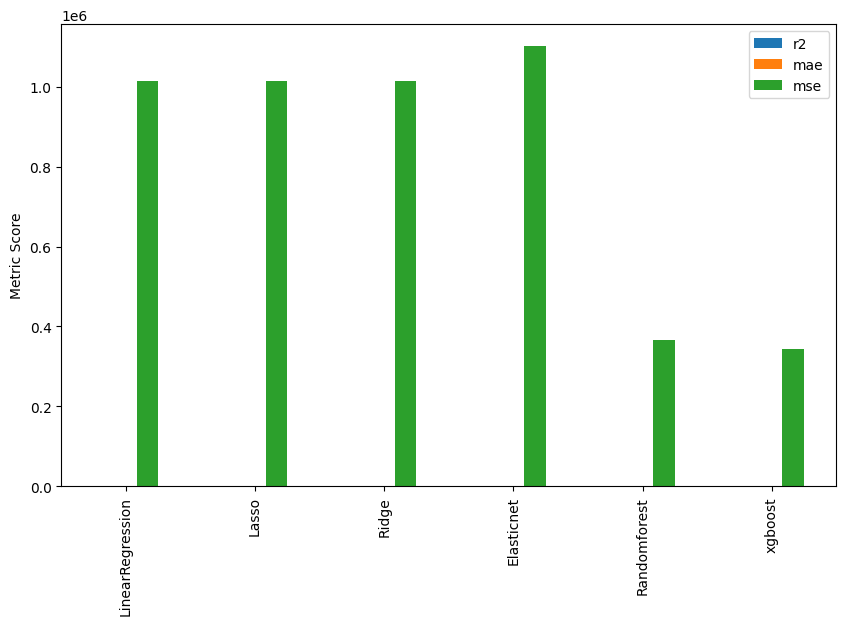

In [34]:
# plot the results
results_df.plot(kind="bar", figsize=(10, 6))
plt.ylabel("Metric Score")
plt.show()

In [1]:
from src.logger.logging import logging

logging.info("Model training completed")

2024-05-29 09:44:33,074 - root - INFO - Model training completed
